In [2]:
import xarray as xr
import numpy as np
import os 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import h5py
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter
from matplotlib.path import Path
from datetime import datetime
from scipy.spatial import cKDTree as KDTree
%matplotlib inline

In [3]:
# import netcdf files for along slope velocity and bathymetry, output from Along_Slope_Velocity.ipynb 

os.chdir('/data/globus/zkaufman')

# vertically averaged from 0-500m
u_along_0_500 = xr.open_dataset("u_along_0_500.nc").u_along
# all depths 
u_along = xr.open_dataset("u_along_fulldepth.nc").u_along

bathym_on_uv = xr.open_dataset("bathym_on_uv.nc").bathymetry

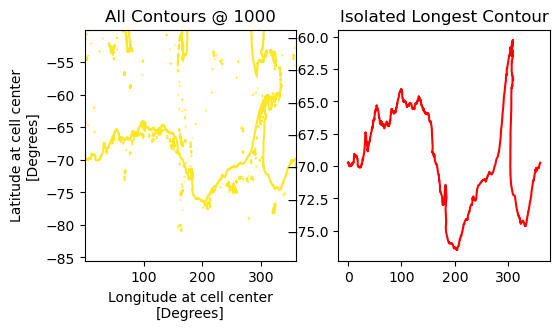

In [4]:
# Get coordinates of 1000m circumpolar isobath using James Milward's "longest path" function 


def iso_contour(da, level, figsize=(6, 3), imshow=True):
    """
    Return the longest contour line (x,y) for a single contour level.
    Works with xarray's .plot.contour across Matplotlib/xarray versions.
    """
    # Two panels only if we want to visualize
    if imshow:
        fig, ax = plt.subplots(ncols=2, figsize=figsize)
        ax0, ax1 = ax
    else:
        fig, ax0 = plt.subplots(ncols=1, figsize=figsize)
        ax1 = None

    # Draw the contour (single level)
    cs = da.plot.contour(ax=ax0, levels=[level], add_colorbar=False)
    ax0.set_title(f"All Contours @ {level}")

    # Get all segments at this (single) level
    # cs.allsegs is a list of levels; each item is a list of (N_i,2) arrays
    seglists = cs.allsegs
    if not seglists or not seglists[0]:
        plt.close(fig)
        raise ValueError(f"No contour segments found at level {level}.")

    # Choose the longest segment by number of vertices
    longest = max(seglists[0], key=lambda seg: seg.shape[0])
    xaxis_coords, yaxis_coords = longest[:, 0], longest[:, 1]

    if ax1 is not None:
        ax1.plot(xaxis_coords, yaxis_coords, 'r-', lw=1.5)
        ax1.set_title("Isolated Longest Contour")

    if not imshow:
        plt.close(fig)

    return xaxis_coords, yaxis_coords

x1000, y1000   = iso_contour(bathym_on_uv, 1000,  imshow=True)

In [5]:
# functions for creating cross-slope transects along the 1000m isobath. Default: ten gridcells in either direction from central point 

def _metric_xy(lon, lat, R=6371000.0):
    """Return metric scale factors (meters per degree) at each lat for lon/lat grids."""
    lat_rad = np.deg2rad(lat)
    # dx per degree lon, dy per degree lat (meters)
    dx = (np.pi/180.0) * R * np.cos(lat_rad)
    dy = (np.pi/180.0) * R * np.ones_like(lat_rad)
    return dx, dy

def _grad_xy(h, lon_name="lon", lat_name="lat", R=6371000.0):
    """∂h/∂x, ∂h/∂y in meters using spherical metrics (matches your earlier function)."""
    dh_dlon = h.differentiate(lon_name, edge_order=2)
    dh_dlat = h.differentiate(lat_name, edge_order=2)

    lat = h[lat_name]
    factor = 180.0/np.pi
    dh_dlambda = dh_dlon * factor
    dh_dphi    = dh_dlat * factor

    lat_rad = xr.apply_ufunc(np.deg2rad, lat)
    dh_dx = (1.0 / (R*np.cos(lat_rad))) * dh_dlambda
    dh_dy = (1.0 / R) * dh_dphi
    return dh_dx, dh_dy

def _flatten_coords(lon2d, lat2d):
    pts = np.column_stack([lon2d.ravel(), lat2d.ravel()])
    return pts

def _nearest_grid_indices(x_contour, y_contour, lon2d, lat2d):
    """Map contour (lon,lat) polyline to nearest grid-cell centers (i,j) preserving order."""
    pts = _flatten_coords(lon2d, lat2d)
    if KDTree is not None:
        tree = KDTree(pts)
        d, idx = tree.query(np.column_stack([x_contour, y_contour]))
    else:
        # Fallback (vectorized, but slower for large grids)
        C = np.column_stack([x_contour, y_contour])[:, None, :]      # (M,1,2)
        G = pts[None, :, :]                                          # (1,N,2)
        idx = np.argmin(np.sum((C - G)**2, axis=-1), axis=1)         # (M,)
    j, i = np.unravel_index(idx, lon2d.shape)
    # Drop duplicates while preserving first occurrence to keep a smooth path
    unique, keep = np.unique(np.stack([j, i], axis=1), axis=0, return_index=True)
    order = np.argsort(keep)
    ij = unique[order]   # shape (K, 2) with (j,i) along the isobath
    return ij[:,0], ij[:,1]  # rows=j, cols=i

def _pick_best_neighbor(j, i, n_hat_xy, lon2d, lat2d, sign=+1):
    """Choose the neighbor (8-connected) whose center advances most along ±n̂."""
    J, I = lon2d.shape
    # 8-neighborhood offsets
    dj = np.array([-1,-1,-1, 0,0, 1,1,1])
    di = np.array([-1, 0, 1,-1,1,-1,0,1])

    cand_j = j + dj
    cand_i = i + di
    valid = (cand_j>=0) & (cand_j<J) & (cand_i>=0) & (cand_i<I)
    if not np.any(valid):
        return None

    cj, ci = cand_j[valid], cand_i[valid]

    # Displacements in meters from center (j,i) → (cj,ci)
    dx_deg = lon2d[cj, ci] - lon2d[j, i]
    dy_deg = lat2d[cj, ci] - lat2d[j, i]
    # metric conversion (meters per degree) at the *current* latitude
    dx_m_per_deg, dy_m_per_deg = _metric_xy(lon2d[j, i], lat2d[j, i])
    # note _metric_xy accepts scalars or arrays; here lon value is unused in dx scaling
    dx = dx_deg * dx_m_per_deg
    dy = dy_deg * dy_m_per_deg

    disp = np.stack([dx, dy], axis=1)                 # (M,2)
    proj = sign * (disp @ n_hat_xy)                   # scalar projection along ±n̂
    proj[proj <= 0] = -np.inf                         # do not step backwards/sideways
    if np.all(~np.isfinite(proj)):
        return None

    k = int(np.nanargmax(proj))
    return int(cj[k]), int(ci[k])

def build_isobath_walk_and_transects(
    u_along: xr.DataArray,
    h: xr.DataArray,
    x_contour: np.ndarray,
    y_contour: np.ndarray,
    lat_name: str = "lat",
    lon_name: str = "lon",
    steps_each_side: int = 10,
    slope_eps: float = 1e-10,
    mask: xr.DataArray | None = None,
) -> dict:
    """
    Parameters
    ----------
    u_along : DataArray (lat,lon)
    h       : DataArray (lat,lon) bathymetry (positive down or up; only gradients matter)
    x_contour, y_contour : 1D arrays with the 1000 m isobath polyline (lon,lat)
    steps_each_side : number of grid steps along the normal direction on each side
    mask    : optional boolean DataArray on (lat,lon); if provided, invalid cells are skipped

    Returns
    -------
    result : dict with
        'path_ij'       : ndarray (K,2) of (j,i) cells closest to the isobath, ordered
        'path_lonlat'   : ndarray (K,2) of (lon,lat) at those cells
        'transects_ij'  : list of ndarrays, each (L,2) indices along the full transect
        'transects_ll'  : list of ndarrays, each (L,2) lon/lat along the transect
        'transects_vals': list of ndarrays, each (L,) u_along values sampled along transect
    """
    # Prepare grids
    lon = u_along[lon_name].values
    lat = u_along[lat_name].values
    lon2d, lat2d = np.meshgrid(lon, lat)

    # Map polyline → nearest grid cells and keep ordered unique path
    jj, ii = _nearest_grid_indices(x_contour, y_contour, lon2d, lat2d)
    path_ij = np.stack([jj, ii], axis=1)

    # Compute metric gradients for normals (∇h / |∇h|)
    dh_dx, dh_dy = _grad_xy(h, lon_name=lon_name, lat_name=lat_name)
    gnx = dh_dx.values
    gny = dh_dy.values
    gnorm = np.hypot(gnx, gny)
    # Avoid division by zero
    gnx = np.where(gnorm > slope_eps, gnx/gnorm, 0.0)
    gny = np.where(gnorm > slope_eps, gny/gnorm, 0.0)

    # Optional mask
    mask_arr = mask.values if mask is not None else None
    J, I = lon2d.shape

    transects_ij = []
    transects_ll = []
    transects_vals = []

    for j0, i0 in path_ij:
        # Skip flat or masked centers
        if gnorm[j0, i0] <= slope_eps:
            continue
        if mask_arr is not None and (not mask_arr[j0, i0]):
            continue

        n_hat = np.array([gnx[j0, i0], gny[j0, i0]])  # unit normal (upslope)

        # Grow +normal
        seg_plus = [(j0, i0)]
        j, i = j0, i0
        for _ in range(steps_each_side):
            nxt = _pick_best_neighbor(j, i, n_hat, lon2d, lat2d, sign=+1)
            if nxt is None:
                break
            j, i = nxt
            if mask_arr is not None and (not mask_arr[j, i]):
                break
            seg_plus.append((j, i))

        # Grow -normal
        seg_minus = []
        j, i = j0, i0
        for _ in range(steps_each_side):
            nxt = _pick_best_neighbor(j, i, n_hat, lon2d, lat2d, sign=-1)
            if nxt is None:
                break
            j, i = nxt
            if mask_arr is not None and (not mask_arr[j, i]):
                break
            seg_minus.append((j, i))

        # Combine (-) reversed + center + (+)
        seg = list(reversed(seg_minus)) + seg_plus
        seg_arr = np.array(seg, dtype=int)
        transects_ij.append(seg_arr)

        seg_ll = np.column_stack([lon2d[seg_arr[:,0], seg_arr[:,1]],
                                  lat2d[seg_arr[:,0], seg_arr[:,1]]])
        transects_ll.append(seg_ll)

        vals = u_along.values[seg_arr[:,0], seg_arr[:,1]]
        transects_vals.append(vals)

    result = dict(
        path_ij = path_ij,
        path_lonlat = np.column_stack([lon2d[path_ij[:,0], path_ij[:,1]],
                                       lat2d[path_ij[:,0], path_ij[:,1]]]),
        transects_ij = transects_ij,
        transects_ll = transects_ll,
        transects_vals = transects_vals,
    )
    return result




res = build_isobath_walk_and_transects(
    u_along=u_along_0_500.squeeze(),
    h=bathym_on_uv,
    x_contour=x1000,
    y_contour=y1000,
    lat_name="lat",
    lon_name="lon",
    steps_each_side=50,      # change as you like
    slope_eps=1e-10,
    mask=None                # or a boolean DataArray (True = keep) to clip land/ice/etc.
)

# Example: get the j/i of the along-isobath path and the transect’s lon/lat and values
path_ij         = res["path_ij"]           # (K,2)
tran_ll   = res["transects_ll"]   # (L,2) lon/lat
tran_vals = res["transects_vals"] # (L,) u_along samples

/tmp/ipykernel_3200068/3033782953.py:125: RuntimeWarning: invalid value encountered in divide
  gnx = np.where(gnorm > slope_eps, gnx/gnorm, 0.0)
/tmp/ipykernel_3200068/3033782953.py:126: RuntimeWarning: invalid value encountered in divide
  gny = np.where(gnorm > slope_eps, gny/gnorm, 0.0)


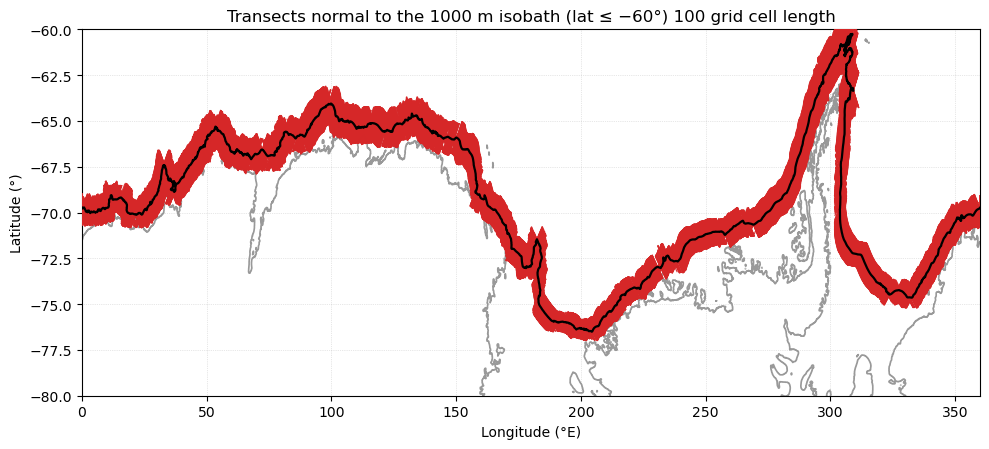

In [9]:
# ---------- helpers ----------
def to360(lon):
    """Map lon array (any shape) to [0, 360)."""
    return np.mod(lon, 360.0)

def clip_poleward(lat_arr, lon_arr, lat_thresh=-60.0):
    m = lat_arr <= lat_thresh
    lon_out = np.where(m, lon_arr, np.nan)
    lat_out = np.where(m, lat_arr, np.nan)
    return lat_out, lon_out

def break_on_wrap(lon, lat, thresh=180.0):
    """
    Insert NaNs where |Δlon| > thresh (e.g., crossing 0/360) so the polyline
    is split into separate segments instead of drawing a spurious straight line.
    """
    lon = np.asarray(lon, float).copy()
    lat = np.asarray(lat, float).copy()
    dlon = np.abs(np.diff(lon))
    # places where we should break the line
    cut = np.where(dlon > thresh)[0] + 1
    if cut.size == 0:
        return lon, lat
    # build new arrays with NaNs inserted at cut points
    lon_out = []
    lat_out = []
    start = 0
    for c in cut:
        lon_out.append(lon[start:c])
        lat_out.append(lat[start:c])
        lon_out.append([np.nan])
        lat_out.append([np.nan])
        start = c
    lon_out.append(lon[start:])
    lat_out.append(lat[start:])
    return np.concatenate(lon_out), np.concatenate(lat_out)

# ---------- prep data on common frame: 0..360 ----------
# 1000 m isobath polyline from iso_contour
x1000_plot = to360(np.asarray(x1000))
y1000_plot = np.asarray(y1000)
y1000_plot, x1000_plot = clip_poleward(y1000_plot, x1000_plot, lat_thresh=-60.0)
x1000_plot, y1000_plot = break_on_wrap(x1000_plot, y1000_plot, thresh=180.0)

# Bathymetry for coastline (assumes bathym_on_uv on (lat,lon))
bathy_0360 = bathym_on_uv.assign_coords(lon=to360(bathym_on_uv.lon)).sortby("lon")

# ---------- figure ----------
fig, ax = plt.subplots(figsize=(10, 4.6))

# (A) light background contours (optional)
try:
    bathy_0360.plot.contour(ax=ax, levels=[500, 1500], colors=[0.85, 0.85],
                            linewidths=0.6, add_colorbar=False)
except Exception:
    pass

# (B) coastline (h = 0) in gray
bathy_0360.plot.contour(ax=ax, levels=[0.0], colors='0.6', linewidths=1.2, add_colorbar=False)

# (C) 1000 m isobath (from x1000,y1000) in black
ax.plot(x1000_plot, y1000_plot, 'k-', lw=1.6, zorder=5, label='1000 m isobath')

# (D) cross-slope transects in red; plot every Nth if crowded
skip = 1
for seg in res["transects_ll"][::skip]:
    lon_seg = to360(seg[:, 0].astype(float))
    lat_seg = seg[:, 1].astype(float)
    # clip to lat ≤ -60 and break on wrap
    lat_plot, lon_plot = clip_poleward(lat_seg, lon_seg, lat_thresh=-60.0)
    lon_plot, lat_plot = break_on_wrap(lon_plot, lat_plot, thresh=180.0)
    # if everything is NaN, skip
    if np.all(np.isnan(lon_plot)):
        continue
    ax.plot(lon_plot, lat_plot, '-', lw=0.9, color='tab:red', alpha=0.9, zorder=4)

# axes & domain: 0..360, poleward of 60S
ax.set_xlim(0, 360)
ax.set_ylim(-80, -60)
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°)")
ax.set_title("Transects normal to the 1000 m isobath (lat ≤ −60°) 100 grid cell length")
ax.grid(True, ls=":", lw=0.5, alpha=0.6)

plt.tight_layout()

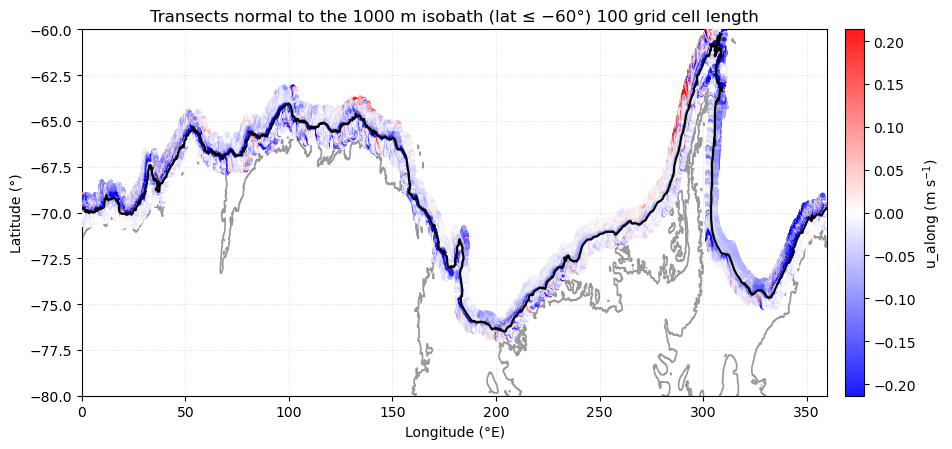

In [6]:
# plot cross-slope transects (circumpolar) relative to 1000m isobath 

# --- helpers ---
def to360(lon):
    return np.mod(lon, 360.0)

def clip_poleward(lat_arr, lon_arr, lat_thresh=-60.0):
    m = lat_arr <= lat_thresh
    lon_out = np.where(m, lon_arr, np.nan)
    lat_out = np.where(m, lat_arr, np.nan)
    return lat_out, lon_out

def break_on_wrap(lon, lat, thresh=180.0):
    lon = np.asarray(lon, float).copy()
    lat = np.asarray(lat, float).copy()
    dlon = np.abs(np.diff(lon))
    cut = np.where(dlon > thresh)[0] + 1
    if cut.size == 0:
        return lon, lat
    lon_out, lat_out, start = [], [], 0
    for c in cut:
        lon_out.append(lon[start:c]); lat_out.append(lat[start:c])
        lon_out.append([np.nan]);     lat_out.append([np.nan])
        start = c
    lon_out.append(lon[start:]); lat_out.append(lat[start:])
    return np.concatenate(lon_out), np.concatenate(lat_out)

# -------- 1) Prep coastline bathy (0..360) & 1000 m isobath line --------
bathy_0360 = bathym_on_uv.assign_coords(lon=to360(bathym_on_uv.lon)).sortby("lon")

# (optional) drop duplicate seam if present
lon_vals = bathy_0360.lon.values
if np.isclose(float(lon_vals[-1] - lon_vals[0]), 360.0):
    bathy_0360 = bathy_0360.isel(lon=slice(0, -1))

x1000_plot = to360(np.asarray(x1000))
y1000_plot = np.asarray(y1000)
y1000_plot, x1000_plot = clip_poleward(y1000_plot, x1000_plot, lat_thresh=-60.0)
x1000_plot, y1000_plot = break_on_wrap(x1000_plot, y1000_plot, thresh=180.0)

# -------- 2) Gather transect points & values --------
# res["transects_ll"] is list of (L,2) [lon,lat]; res["transects_vals"] is list of (L,)
lon_pts, lat_pts, val_pts = [], [], []
skip = 1  # increase (e.g., 2–5) if there are too many points

for seg_ll, seg_vals in zip(res["transects_ll"][::skip], res["transects_vals"][::skip]):
    lon_seg = to360(seg_ll[:, 0].astype(float))
    lat_seg = seg_ll[:, 1].astype(float)
    vals    = np.asarray(seg_vals, float)

    # Clip to lat ≤ -60 and drop masked points
    lat_clp, lon_clp = clip_poleward(lat_seg, lon_seg, lat_thresh=-60.0)
    keep = ~np.isnan(lon_clp)
    if not np.any(keep):
        continue

    lon_pts.append(lon_clp[keep]); lat_pts.append(lat_clp[keep]); val_pts.append(vals[keep])

# Concatenate all transect points
if len(lon_pts) == 0:
    raise RuntimeError("No transect points survived clipping; check inputs/lat threshold.")
lon_pts = np.concatenate(lon_pts)
lat_pts = np.concatenate(lat_pts)
val_pts = np.concatenate(val_pts)

# Symmetric color limits around 0 (robust option shown)
# vmax = np.nanmax(np.abs(val_pts))                      # strict max
v95  = np.nanpercentile(np.abs(val_pts), 95)             # robust: avoid outliers
vmax = float(v95) if np.isfinite(v95) and v95 > 0 else float(np.nanmax(np.abs(val_pts)))
vmin = -vmax

# -------- 3) Plot --------
fig, ax = plt.subplots(figsize=(10, 4.6))

# light context (optional)
try:
    bathy_0360.plot.contour(ax=ax, levels=[500, 1500], colors=[0.85, 0.85],
                            linewidths=0.6, add_colorbar=False)
except Exception:
    pass

# coastline from h=0 (gray)
bathy_0360.plot.contour(ax=ax, levels=[0.0], colors='0.6', linewidths=1.2, add_colorbar=False)

# 1000 m isobath from (x1000,y1000) (black)
ax.plot(x1000_plot, y1000_plot, 'k-', lw=1.6, zorder=5, label='1000 m isobath')

# transect points colored by u_along
sc = ax.scatter(lon_pts, lat_pts, c=val_pts, s=8, cmap='bwr', vmin=vmin, vmax=vmax,
                edgecolors='none', alpha=0.9, zorder=4)

# colorbar, centered on zero
cb = fig.colorbar(sc, ax=ax, pad=0.02)
cb.set_label("u_along (m s$^{-1}$)")

ax.set_xlim(0, 360)
ax.set_ylim(-80, -60)
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°)")
ax.set_title("Transects normal to the 1000 m isobath (lat ≤ −60°) 100 grid cell length")
ax.grid(True, ls=":", lw=0.5, alpha=0.6)
plt.tight_layout()

/tmp/ipykernel_3200068/1450310422.py:74: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm = ax.pcolormesh(X, Y, vals, cmap="bwr", vmin=vmin, vmax=vmax, shading="nearest")


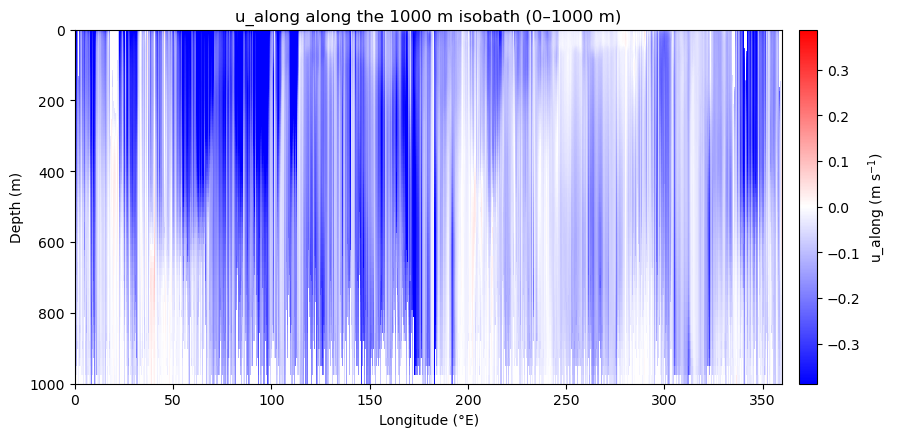

In [7]:

# plot along-slope velocity on transect vs. depth plot following the 1000m isobath 

def to360(lon):
    return np.mod(lon, 360.0)

def nearest_path_indices(x_contour, y_contour, lon1d, lat1d):
    """Map the (x1000,y1000) polyline onto nearest (lat,lon) grid indices, preserving order."""
    lon2d, lat2d = np.meshgrid(lon1d, lat1d)
    pts = np.column_stack([lon2d.ravel(), lat2d.ravel()])
    Q = np.column_stack([x_contour, y_contour])
    if KDTree is not None:
        _, idx = KDTree(pts).query(Q)
    else:
        idx = np.argmin(((Q[:,None,:]-pts[None,:,:])**2).sum(-1), axis=1)
    j, i = np.unravel_index(idx, lon2d.shape)  # j=lat index, i=lon index
    # de-duplicate while keeping first occurrence to keep an ordered walk
    uniq, keep = np.unique(np.stack([j,i], axis=1), axis=0, return_index=True)
    order = np.argsort(keep)
    ij = uniq[order]
    return ij[:,0], ij[:,1]  # (jj, ii)

# ---------- 1) Prepare u_along on a 0..360° longitude frame ----------
ua = u_along.isel(date=0)                  # pick the date you want
ua = ua.assign_coords(lon=to360(ua.lon)).sortby("lon")

# (optional) drop a duplicate seam if present (0 and 360 both in coords)
lon_vals = ua.lon.values
if np.isclose(float(lon_vals[-1] - lon_vals[0]), 360.0):
    ua = ua.isel(lon=slice(0, -1))

# ---------- 2) Decide which depth coordinate to use: 0..1000 m (positive down) ----------
depth = ua["depth"].values
# If your depth is negative downward (as in your screenshot), flip sign for plotting:
if np.nanmedian(depth) < 0:
    z_plot = -depth          # positive downward
else:
    z_plot = depth.copy()

# take only 0..1000 m for the section
kz = np.where((z_plot >= 0.0) & (z_plot <= 1000.0))[0]
if kz.size == 0:
    raise RuntimeError("No depth levels between 0 and 1000 m found.")
ua_0_1000 = ua.isel(depth=kz)
z_plot_0_1000 = z_plot[kz]

# ---------- 3) Map the 1000 m isobath polyline to nearest grid cells ----------
x1000_0360 = to360(np.asarray(x1000))
y1000_arr  = np.asarray(y1000)
jj, ii = nearest_path_indices(x1000_0360, y1000_arr, ua_0_1000.lon.values, ua_0_1000.lat.values)

# ---------- 4) Sample u_along along the path (depth × s) and build lon/depth grids ----------
# Advanced indexing to get shape (depth, s)
s_dim = xr.DataArray(np.arange(ii.size), dims="s")
Usec = ua_0_1000.isel(lat=xr.DataArray(jj, dims="s"), lon=xr.DataArray(ii, dims="s"))

# Longitude at each along-isobath point (0..360), repeated down the column to plot
lon_path = ua_0_1000.lon.values[ii]        # (s,)
# 2D grids for pcolormesh/contourf
X = np.tile(lon_path, (z_plot_0_1000.size, 1))          # (depth, s)
Y = np.tile(z_plot_0_1000[:, None], (1, lon_path.size)) # (depth, s)

# ---------- 5) Plot: longitude (x) × depth (y), colored by u_along ----------
vals = Usec.values  # (depth, s)

# zero-centered symmetric color limits (robust against outliers)
v95 = np.nanpercentile(np.abs(vals), 95)
vmax = float(v95) if np.isfinite(v95) and v95 > 0 else float(np.nanmax(np.abs(vals)))
vmin = -vmax

fig, ax = plt.subplots(figsize=(11, 4.6))

# We can use pcolormesh; it tolerates repeated/non-monotonic columns.
# To avoid “checkerboard” gaps, use shading='nearest' (mpl>=3.3) or 'auto'
pcm = ax.pcolormesh(X, Y, vals, cmap="bwr", vmin=vmin, vmax=vmax, shading="nearest")

# Axes styling
ax.set_xlim(0, 360)
ax.set_ylim(1000, 0)  # plot depth increasing downward
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Depth (m)")
ax.set_title("u_along along the 1000 m isobath (0–1000 m)")

# Colorbar
cb = fig.colorbar(pcm, ax=ax, pad=0.02)
cb.set_label("u_along (m s$^{-1}$)")


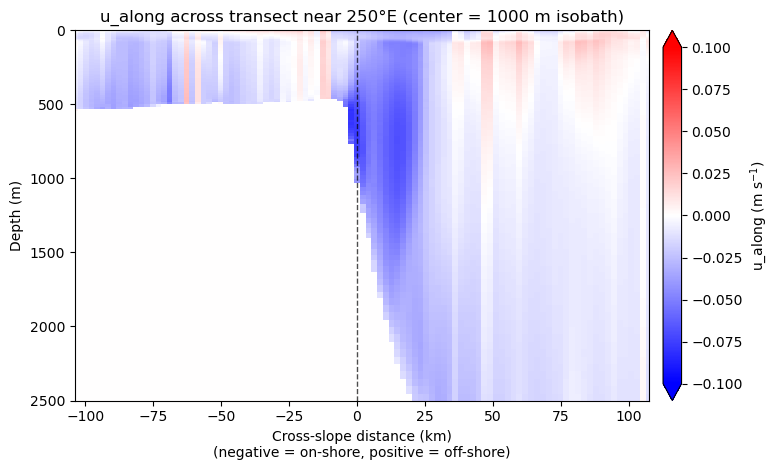

In [14]:
# sample a transect at 250E

# ---------------- helpers ----------------
def to360(lon): return np.mod(lon, 360.0)

R = 6371000.0
def step_distance_m(lon0, lat0, lon1, lat1, R=R):
    """Local 
    planar metric step distance (meters)."""
    latm = np.deg2rad(0.5*(lat0 + lat1))
    dlon = np.deg2rad(lon1 - lon0)
    dlat = np.deg2rad(lat1 - lat0)
    dx = R*np.cos(latm)*dlon
    dy = R*dlat
    return float(np.hypot(dx, dy))

def signed_transect_distance_km(seg_ll, seg_ij, center_ij):
    """
    Build signed distances with 0 at the center (isobath) cell.
    Returns s_km (L,), center_idx (int).
    """
    cj, ci = center_ij
    # locate the center within this transect
    center_idx = int(np.where((seg_ij[:,0]==cj) & (seg_ij[:,1]==ci))[0][0])
    L = seg_ll.shape[0]
    s = np.zeros(L, dtype=float)
    # + side
    for i in range(center_idx, L-1):
        s[i+1] = s[i] + step_distance_m(seg_ll[i,0], seg_ll[i,1],
                                        seg_ll[i+1,0], seg_ll[i+1,1])
    # − side
    for i in range(center_idx, 0, -1):
        s[i-1] = s[i] - step_distance_m(seg_ll[i-1,0], seg_ll[i-1,1],
                                        seg_ll[i,0], seg_ll[i,1])
    return s/1000.0, center_idx  # km

# ---------------- 1) choose the transect nearest 250°E ----------------
# res must be from the earlier build_isobath_walk_and_transects()
path_lon = to360(res["path_lonlat"][:,0])           # lon of each transect's center
k = int(np.argmin(np.abs(path_lon - 250.0)))        # index of nearest center to 250°E

seg_ll = res["transects_ll"][k]                     # (L,2) lon,lat along the transect
seg_ij = res["transects_ij"][k]                     # (L,2) j,i along the transect
center_ij = tuple(res["path_ij"][k])                # (j,i) center (on 1000 m isobath)

# make sure longitudes are 0..360
seg_ll = seg_ll.copy()
seg_ll[:,0] = to360(seg_ll[:,0])

# ---------------- 2) compute signed distances and orient on-/off-shore ----------------
s_km, cidx = signed_transect_distance_km(seg_ll, seg_ij, center_ij)

# Decide which side is on-shore (shallower) using bathymetry at a few points
jj, ii = seg_ij[:,0], seg_ij[:,1]
h_tr = bathym_on_uv.values[jj, ii]  # depth at transect points (positive down)
# means close to the center on each side (guard for short sides)
w = 3
left_mean  = np.nanmean(h_tr[max(0, cidx-w):cidx])          if cidx>0 else np.nan
right_mean = np.nanmean(h_tr[cidx+1:min(len(h_tr), cidx+1+w)]) if cidx < len(h_tr)-1 else np.nan

# negative distances should be on-shore (shallower = smaller depth)
# if left side is *deeper* than right, flip the sign so the shallower side is negative
if np.isfinite(left_mean) and np.isfinite(right_mean) and left_mean > right_mean:
    s_km = -s_km  # flip sign so negative = shallower (on-shore)

# ---------------- 3) sample u_along(depth, lat, lon) along the transect ----------------
ua3 = u_along.isel(date=0)                            # pick date of interest
ua3 = ua3.assign_coords(lon=to360(ua3.lon)).sortby("lon")

# optional: drop duplicate seam
lon_vals = ua3.lon.values
if np.isclose(float(lon_vals[-1] - lon_vals[0]), 360.0):
    ua3 = ua3.isel(lon=slice(0, -1))

# select 0..2500 m (plot positive down)
depth = ua3["depth"].values
z_plot = -depth if np.nanmedian(depth) < 0 else depth
kz = np.where((z_plot >= 0.0) & (z_plot <= 2500.0))[0]
ua_sec = ua3.isel(depth=kz)
z_sec  = z_plot[kz]

# Advanced indexing to get array (depth, along_transect)
Usec = ua_sec.isel(lat=xr.DataArray(jj, dims="s"),
                   lon=xr.DataArray(ii, dims="s"))     # (depth, L)
vals = Usec.values

# ---------------- 4) plot distance × depth (u_along) ----------------
X = np.tile(s_km, (z_sec.size, 1))          # (depth, L)
Y = np.tile(z_sec[:, None], (1, s_km.size)) # (depth, L)
vals = Usec.values

# hard-coded color limits
vmin, vmax = -0.1, 0.1

# set colormap and bad (NaN) color to dark gray
cmap = plt.get_cmap("bwr").copy()
cmap.set_bad(color="0.2")   # dark gray background for NaNs

fig, ax = plt.subplots(figsize=(8, 4.8))
pcm = ax.pcolormesh(X, Y, vals, cmap=cmap, vmin=vmin, vmax=vmax, shading="nearest")
ax.axvline(0.0, color='k', ls='--', lw=1.0, alpha=0.7)

ax.set_xlim(np.nanmin(s_km), np.nanmax(s_km))
ax.set_ylim(2500, 0)  # depth increasing downward
ax.set_xlabel("Cross-slope distance (km)\n(negative = on-shore, positive = off-shore)")
ax.set_ylabel("Depth (m)")
ax.set_title("u_along across transect near 250°E (center = 1000 m isobath)")

cb = fig.colorbar(pcm, ax=ax, pad=0.02, extend="both")
cb.set_label("u_along (m s$^{-1}$)")

plt.tight_layout()

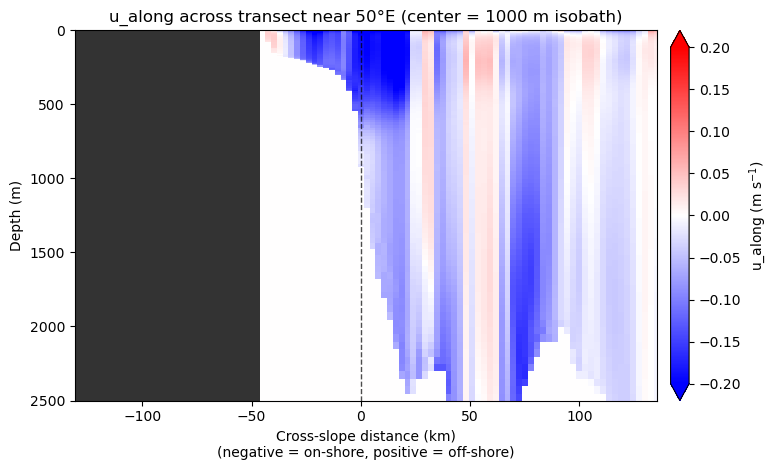

In [17]:
# sample a transect at 50E

# ---------------- helpers ----------------
def to360(lon): return np.mod(lon, 360.0)

R = 6371000.0
def step_distance_m(lon0, lat0, lon1, lat1, R=R):
    """Local 
    planar metric step distance (meters)."""
    latm = np.deg2rad(0.5*(lat0 + lat1))
    dlon = np.deg2rad(lon1 - lon0)
    dlat = np.deg2rad(lat1 - lat0)
    dx = R*np.cos(latm)*dlon
    dy = R*dlat
    return float(np.hypot(dx, dy))

def signed_transect_distance_km(seg_ll, seg_ij, center_ij):
    """
    Build signed distances with 0 at the center (isobath) cell.
    Returns s_km (L,), center_idx (int).
    """
    cj, ci = center_ij
    # locate the center within this transect
    center_idx = int(np.where((seg_ij[:,0]==cj) & (seg_ij[:,1]==ci))[0][0])
    L = seg_ll.shape[0]
    s = np.zeros(L, dtype=float)
    # + side
    for i in range(center_idx, L-1):
        s[i+1] = s[i] + step_distance_m(seg_ll[i,0], seg_ll[i,1],
                                        seg_ll[i+1,0], seg_ll[i+1,1])
    # − side
    for i in range(center_idx, 0, -1):
        s[i-1] = s[i] - step_distance_m(seg_ll[i-1,0], seg_ll[i-1,1],
                                        seg_ll[i,0], seg_ll[i,1])
    return s/1000.0, center_idx  # km

# ---------------- 1) choose the transect nearest 250°E ----------------
# res must be from the earlier build_isobath_walk_and_transects()
path_lon = to360(res["path_lonlat"][:,0])           # lon of each transect's center
k = int(np.argmin(np.abs(path_lon - 50.0)))        # index of nearest center to 250°E

seg_ll = res["transects_ll"][k]                     # (L,2) lon,lat along the transect
seg_ij = res["transects_ij"][k]                     # (L,2) j,i along the transect
center_ij = tuple(res["path_ij"][k])                # (j,i) center (on 1000 m isobath)

# make sure longitudes are 0..360
seg_ll = seg_ll.copy()
seg_ll[:,0] = to360(seg_ll[:,0])

# ---------------- 2) compute signed distances and orient on-/off-shore ----------------
s_km, cidx = signed_transect_distance_km(seg_ll, seg_ij, center_ij)

# Decide which side is on-shore (shallower) using bathymetry at a few points
jj, ii = seg_ij[:,0], seg_ij[:,1]
h_tr = bathym_on_uv.values[jj, ii]  # depth at transect points (positive down)
# means close to the center on each side (guard for short sides)
w = 3
left_mean  = np.nanmean(h_tr[max(0, cidx-w):cidx])          if cidx>0 else np.nan
right_mean = np.nanmean(h_tr[cidx+1:min(len(h_tr), cidx+1+w)]) if cidx < len(h_tr)-1 else np.nan

# negative distances should be on-shore (shallower = smaller depth)
# if left side is *deeper* than right, flip the sign so the shallower side is negative
if np.isfinite(left_mean) and np.isfinite(right_mean) and left_mean > right_mean:
    s_km = -s_km  # flip sign so negative = shallower (on-shore)

# ---------------- 3) sample u_along(depth, lat, lon) along the transect ----------------
ua3 = u_along.isel(date=0)                            # pick date of interest
ua3 = ua3.assign_coords(lon=to360(ua3.lon)).sortby("lon")

# optional: drop duplicate seam
lon_vals = ua3.lon.values
if np.isclose(float(lon_vals[-1] - lon_vals[0]), 360.0):
    ua3 = ua3.isel(lon=slice(0, -1))

# select 0..2500 m (plot positive down)
depth = ua3["depth"].values
z_plot = -depth if np.nanmedian(depth) < 0 else depth
kz = np.where((z_plot >= 0.0) & (z_plot <= 2500.0))[0]
ua_sec = ua3.isel(depth=kz)
z_sec  = z_plot[kz]

# Advanced indexing to get array (depth, along_transect)
Usec = ua_sec.isel(lat=xr.DataArray(jj, dims="s"),
                   lon=xr.DataArray(ii, dims="s"))     # (depth, L)
vals = Usec.values

# ---------------- 4) plot distance × depth (u_along) ----------------
X = np.tile(s_km, (z_sec.size, 1))          # (depth, L)
Y = np.tile(z_sec[:, None], (1, s_km.size)) # (depth, L)
vals = Usec.values

# hard-coded color limits
vmin, vmax = -0.2, 0.2


fig, ax = plt.subplots(figsize=(8, 4.8))
pcm = ax.pcolormesh(X, Y, vals, cmap=cmap, vmin=vmin, vmax=vmax, shading="nearest")
ax.axvline(0.0, color='k', ls='--', lw=1.0, alpha=0.7)

ax.set_xlim(np.nanmin(s_km), np.nanmax(s_km))
ax.set_ylim(2500, 0)  # depth increasing downward
ax.set_xlabel("Cross-slope distance (km)\n(negative = on-shore, positive = off-shore)")
ax.set_ylabel("Depth (m)")
ax.set_title("u_along across transect near 50°E (center = 1000 m isobath)")

cb = fig.colorbar(pcm, ax=ax, pad=0.02, extend="both")
cb.set_label("u_along (m s$^{-1}$)")

plt.tight_layout()